# This part 3 of 3 is TBD very soon <a class='tocSkip'>

**Previous notebooks:** <br>
[Part 1: Data mining and munging](tdp_1_3_data_mining_and_cleaning.ipynb)<br>
[Part 2: Data stats and visuals](tdp_2_3_data_statistics_visualization.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()

### Data loading <a class='tocSkip'>

In [2]:
# Main data for modeling
biker_class = pd.read_csv('processed/clean_biker_class.csv', index_col=0)

# # Additional parts for statistics
# biker_stats = pd.read_csv('preprocessed/pre_biker_stats.csv', index_col=0)
# biker_by_stage = pd.read_csv('preprocessed/pre_biker_by_stage.csv', index_col=0)
# stage_results = pd.read_csv('preprocessed/pre_stages.csv', index_col=False)
# stage_class = pd.read_csv('preprocessed/pre_stages_summary.csv', index_col=False)

In [3]:
# Fixing 'date' type column
biker_class['date'] = pd.to_datetime(biker_class['date'])

# Preparing data

In [4]:
# Baseline prediction for 0s
1 - biker_class.y_label.mean()

0.9352997145575642

In [5]:
# Poping out label column
y = biker_class.pop('y_label')

In [6]:
y[6:15]

6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
Name: y_label, dtype: int64

-------

In [7]:
biker_class.columns

Index(['name', 'nation', 'age', 'team', 'year', 'stage', 'position',
       'time_in_s', 'gc', 'gc_time_in_s', 'mount_jerseys', 'point_jerseys',
       'sprint_jerseys', 'youth_jerseys', 'followers', 'total_wins', 'n_tours',
       'n_stages', 'avg_year', 'best_pos_ovr', 'avg_pos_ovr', 'worst_pos_ovr',
       'best_time_ovr', 'avg_time_ovr', 'worst_time_ovr', 'best_gc_ovr',
       'avg_gc_ovr', 'worst_gc_ovr', 'best_gc_time_ovr', 'avg_gc_time_ovr',
       'worst_gc_time_ovr', 'n_top10_ovr', 'n_win_ovr', 'best_pos_ovr_l3',
       'avg_pos_ovr_l3', 'worst_pos_ovr_l3', 'best_time_ovr_l3',
       'avg_time_ovr_l3', 'worst_time_ovr_l3', 'best_gc_ovr_l3',
       'avg_gc_ovr_l3', 'worst_gc_ovr_l3', 'best_gc_time_ovr_l3',
       'avg_gc_time_ovr_l3', 'worst_gc_time_ovr_l3', 'n_top10_l3', 'n_win_l3',
       'perc_top10_ovr', 'perc_win_ovr', '2015_div', '2015_fc_rank',
       '2015_race_days', '2015_team', '2015_wins', '2015_year_km', '2016_div',
       '2016_fc_rank', '2016_race_days', '2016_te

In [8]:
print(biker_class.shape)
biker_class.head()

(5255, 83)


,name,nation,age,team,year,stage,position,time_in_s,gc,gc_time_in_s,...,date,stage_type_code,dist,finish,temp,rel_humid,wind_dir,wind_speed,clouds_ovrl,visibility
0,Y.Hutarovich,Belarus,31,AG2R La Mondiale,2014,1,1,20870.0,1,20860.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
1,R.Maikin,Russia,24,RusVelo,2014,1,2,20870.0,2,20864.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
2,M.Mori,Italy,34,Lampre - Merida,2014,1,3,20870.0,3,20866.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
3,G.Boivin,Canada,25,Cannondale Pro Cycling,2014,1,4,20870.0,6,20870.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
4,M.Haller,Austria,23,Team Katusha,2014,1,5,20870.0,7,20870.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9


## Remapping & Dropping

In [9]:
# Due to too many levels, trying with the '_team' data removed
# Try: change team levels for only 5 top + 1 as a rest
biker_class.drop('team', axis=1, inplace=True)
biker_class.drop(biker_class.loc[:,'2015_team':'2018_team':6], axis=1, inplace=True)

In [10]:
biker_class.loc[:,'2015_div':'2018_div':5].head()

,2015_div,2016_div,2017_div,2018_div
0,PROF,PROF,NONE,NONE
1,PROF,PROF,PROF,PROF
2,PRT,PRT,PRT,PRT
3,CONT,CONT,PROF,PROF
4,PRT,PRT,PRT,PRT


In [11]:
# Remapping '_div' team types with numbers as they show a true level of professionalism
biker_class.loc[:,'2015_div':'2018_div':5] = biker_class.loc[:,'2015_div':'2018_div':5]\
                                                        .replace({'PRT':1, 'PROF':2, 'CONT':3, 'NONE':4})

In [12]:
biker_class.loc[:,'2015_div':'2018_div':5].head()

,2015_div,2016_div,2017_div,2018_div
0,2,2,4,4
1,2,2,2,2
2,1,1,1,1
3,3,3,2,2
4,1,1,1,1


## Information about features

### Datetime feature (1)

In [13]:
biker_class.select_dtypes('datetime').head()

,date
0,2014-08-03
1,2014-08-03
2,2014-08-03
3,2014-08-03
4,2014-08-03


### Categorical features (4)

In [14]:
biker_class.select_dtypes('object').columns

Index(['name', 'nation', 'finish', 'wind_dir'], dtype='object')

In [15]:
print(biker_class.select_dtypes('object').shape)
biker_class.select_dtypes('object').head(3)

(5255, 4)


,name,nation,finish,wind_dir
0,Y.Hutarovich,Belarus,Bygdoszcz,ESE
1,R.Maikin,Russia,Bygdoszcz,ESE
2,M.Mori,Italy,Bygdoszcz,ESE


### Numeric features (73)

In [16]:
biker_class.select_dtypes('number').columns

Index(['age', 'year', 'stage', 'position', 'time_in_s', 'gc', 'gc_time_in_s',
       'mount_jerseys', 'point_jerseys', 'sprint_jerseys', 'youth_jerseys',
       'followers', 'total_wins', 'n_tours', 'n_stages', 'avg_year',
       'best_pos_ovr', 'avg_pos_ovr', 'worst_pos_ovr', 'best_time_ovr',
       'avg_time_ovr', 'worst_time_ovr', 'best_gc_ovr', 'avg_gc_ovr',
       'worst_gc_ovr', 'best_gc_time_ovr', 'avg_gc_time_ovr',
       'worst_gc_time_ovr', 'n_top10_ovr', 'n_win_ovr', 'best_pos_ovr_l3',
       'avg_pos_ovr_l3', 'worst_pos_ovr_l3', 'best_time_ovr_l3',
       'avg_time_ovr_l3', 'worst_time_ovr_l3', 'best_gc_ovr_l3',
       'avg_gc_ovr_l3', 'worst_gc_ovr_l3', 'best_gc_time_ovr_l3',
       'avg_gc_time_ovr_l3', 'worst_gc_time_ovr_l3', 'n_top10_l3', 'n_win_l3',
       'perc_top10_ovr', 'perc_win_ovr', '2015_div', '2015_fc_rank',
       '2015_race_days', '2015_wins', '2015_year_km', '2016_div',
       '2016_fc_rank', '2016_race_days', '2016_wins', '2016_year_km',
       '2017_div',

In [17]:
print(biker_class.select_dtypes('number').shape)
biker_class.select_dtypes('number').head()

(5255, 73)


,age,year,stage,position,time_in_s,gc,gc_time_in_s,mount_jerseys,point_jerseys,sprint_jerseys,...,2018_race_days,2018_wins,2018_year_km,stage_type_code,dist,temp,rel_humid,wind_speed,clouds_ovrl,visibility
0,31,2014,1,1,20870.0,1,20860.0,0,6,0,...,0.0,0.0,0.0,1,226.0,31.5,38,2,6,9
1,24,2014,1,2,20870.0,2,20864.0,0,2,0,...,44.0,0.0,7349.7,1,226.0,31.5,38,2,6,9
2,34,2014,1,3,20870.0,3,20866.0,0,0,0,...,65.0,0.0,10322.1,1,226.0,31.5,38,2,6,9
3,25,2014,1,4,20870.0,6,20870.0,0,1,0,...,63.0,0.0,10485.0,1,226.0,31.5,38,2,6,9
4,23,2014,1,5,20870.0,7,20870.0,1,0,0,...,17.0,0.0,2733.3,1,226.0,31.5,38,2,6,9


## Transforming features into dummy categories & scaling values

In [18]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [19]:
data_numerics = biker_class.select_dtypes(include = ['number'])
# Skipping 'name' column
data_categorical = biker_class.select_dtypes(exclude = ['number']).iloc[:,1:]

categorical_dummies = pd.get_dummies(data_categorical)

numeric_scaler = StandardScaler()
numerics_scaled = numeric_scaler.fit_transform(data_numerics)
numerics_scaled = pd.DataFrame(numerics_scaled, columns=data_numerics.columns, index=data_numerics.index)

data_adult = pd.concat([biker_class.name, categorical_dummies, numerics_scaled], axis=1)

C:\Users\cyberdeck\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cyberdeck\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
print(data_adult.shape)
data_adult.head()

(5255, 147)


,name,date,nation_Algeria,nation_Argentina,nation_Australia,nation_Austria,nation_Belarus,nation_Belgium,nation_Brazil,nation_Canada,...,2018_race_days,2018_wins,2018_year_km,stage_type_code,dist,temp,rel_humid,wind_speed,clouds_ovrl,visibility
0,Y.Hutarovich,2014-08-03,0,0,0,0,1,0,0,0,...,-1.987928,-0.404551,-1.951352,-0.73624,1.13983,1.405869,-0.032021,-0.443167,0.614099,1.247777
1,R.Maikin,2014-08-03,0,0,0,0,0,0,0,0,...,-0.165444,-0.404551,-0.011144,-0.73624,1.13983,1.405869,-0.032021,-0.443167,0.614099,1.247777
2,M.Mori,2014-08-03,0,0,0,0,0,0,0,0,...,0.704378,-0.404551,0.773524,-0.73624,1.13983,1.405869,-0.032021,-0.443167,0.614099,1.247777
3,G.Boivin,2014-08-03,0,0,0,0,0,0,0,1,...,0.621538,-0.404551,0.816527,-0.73624,1.13983,1.405869,-0.032021,-0.443167,0.614099,1.247777
4,M.Haller,2014-08-03,0,0,0,1,0,0,0,0,...,-1.283787,-0.404551,-1.229803,-0.73624,1.13983,1.405869,-0.032021,-0.443167,0.614099,1.247777


## Modeling

In [21]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from scipy.stats.distributions import uniform, randint

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# Baseline prediction for 0s
1 - y.mean()

0.9352997145575642

In [23]:
# Spliting data depending on the date column (not random), because going down the dataframe it is 'sequencial' data,
# year by year, stage by stage

# Spliting observations to prevent data leakage
# Split made after last stage of year 2017
cutoff = 3120

X_train = data_adult.iloc[:cutoff,:]
X_test = data_adult.iloc[cutoff:,:]

y_train = y[:cutoff]
y_test = y[cutoff:] 

In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3120, 147) (2135, 147)
(3120,) (2135,)


In [25]:
print('Train batch ------------')
print(y_train.value_counts())
print()
print('Test batch -------------')
print(y_test.value_counts())

Train batch ------------
0    2930
1     190
Name: y_label, dtype: int64

Test batch -------------
0    1985
1     150
Name: y_label, dtype: int64


### Baseline

In [26]:
# Helper function plotting Precision-Recall Curve instead of a ROC Curve due to class imbalance

def precission_recall_plot(classifier, X_test):
    # predict probabilities
    probas = classifier.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probas = probas[:, 1]
    # predict class values
    y_pred = classifier.predict(X_test)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probas)
    # calculate F1 score
    f1 = f1_score(y_test, y_pred)
    # calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_test, probas, average='weighted')
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))
    plt.figure(figsize=(5,5))
    # plot no skill model
    plt.plot([0, 1], [0.5, 0.5], linestyle='--', linewidth=1)
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.', markersize=4, color='orangered', linewidth=1)
    # show the plot
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.title('2-class Precision-Recall curve: AP={0:0.3f}'.format(ap))
    plt.show()
    
def balanced_accuracy_value(classifier):
    return balanced_accuracy_score(y_test, classifier.predict(X_test_cut))

In [27]:
X_train_cut = X_train.iloc[:,2:]
X_test_cut = X_test.iloc[:,2:]

**Logistic Regression**

In [28]:
base_lr = LogisticRegression(solver='liblinear')
base_lr.fit(X_train_cut, y_train)
print(classification_report(y_test, base_lr.predict(X_test_cut)))
print('Accuracy: %s' % balanced_accuracy_value(base_lr))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1985
           1       0.76      0.60      0.67       150

   micro avg       0.96      0.96      0.96      2135
   macro avg       0.86      0.79      0.82      2135
weighted avg       0.96      0.96      0.96      2135

Accuracy: 0.7926952141057935


f1=0.669 auc=0.791 ap=0.792


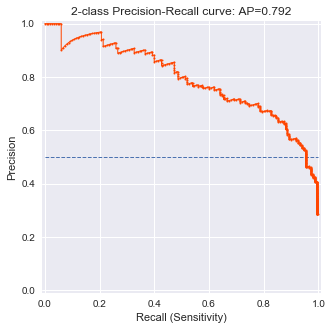

In [29]:
precission_recall_plot(base_lr, X_test_cut)

**Support Vector Machines**

In [78]:
base_svc = SVC(class_weight='balanced', probability=True, gamma='auto', kernel='linear')
base_svc.fit(X_train_cut, y_train)
print(classification_report(y_test, base_svc.predict(X_test_cut)))
print('Accuracy: %s' % balanced_accuracy_value(base_svc))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1985
           1       0.57      0.97      0.72       150

   micro avg       0.95      0.95      0.95      2135
   macro avg       0.78      0.96      0.84      2135
weighted avg       0.97      0.95      0.95      2135

Accuracy: 0.958958858102435


f1=0.719 auc=0.857 ap=0.858


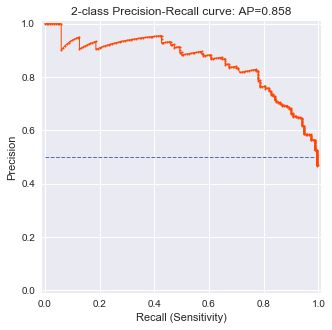

In [79]:
precission_recall_plot(base_svc, X_test_cut)

### Cross-validation

**Logistic Regression**

In [32]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
scores_lr = cross_val_score(X=X_train_cut,
                         y=y_train,
                         estimator=lr,
                         cv=StratifiedKFold(10, shuffle=True),
                         scoring='balanced_accuracy',
                         n_jobs=-1)
lr.fit(X_train_cut, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [33]:
print(classification_report(lr.predict(X_test_cut), y_test))
print('Accuracy: %s' % scores_lr.mean())

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1796
           1       0.99      0.44      0.61       339

   micro avg       0.91      0.91      0.91      2135
   macro avg       0.95      0.72      0.78      2135
weighted avg       0.92      0.91      0.90      2135

Accuracy: 0.930393389617388


f1=0.609 auc=0.816 ap=0.817


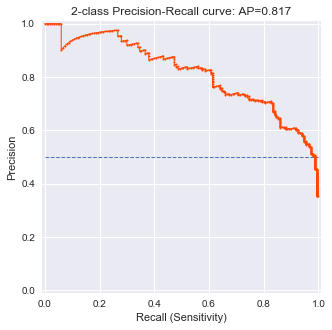

In [34]:
precission_recall_plot(lr, X_test_cut)

**Support Vector Machines**

In [80]:
svc = SVC(class_weight='balanced', probability=True, random_state=42, gamma='auto', kernel='linear')
scores_svc = cross_val_score(X=X_train_cut,
                         y=y_train,
                         estimator=svc,
                         cv=StratifiedKFold(10, shuffle=True),
                         scoring='balanced_accuracy',
                         n_jobs=-1)

In [81]:
svc.fit(X_train_cut, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
print(classification_report(svc.predict(X_test_cut), y_test))
print('Accuracy: %s' % scores_svc.mean())

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1879
           1       0.97      0.57      0.72       256

   micro avg       0.95      0.95      0.95      2135
   macro avg       0.96      0.78      0.84      2135
weighted avg       0.95      0.95      0.94      2135

Accuracy: 0.9238189329980241


f1=0.719 auc=0.857 ap=0.858


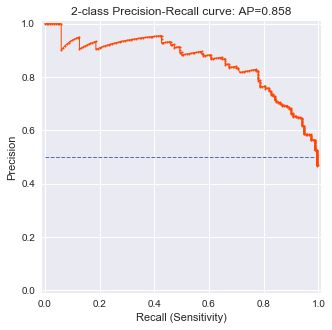

In [83]:
precission_recall_plot(svc, X_test_cut)

### Param grid with RandomizedSearchCV

**Logistic Regression**

In [39]:
param_grid_lr = {'penalty':['l1','l2'],
              'C':uniform(0.25,10.0-0.25)}

In [40]:
grid_lr = RandomizedSearchCV(
                        n_iter=40, 
                        estimator=lr, 
                        cv=StratifiedKFold(10, shuffle=True), 
                        param_distributions=param_grid_lr,
                        scoring='balanced_accuracy',
                        n_jobs=-1
                        )

In [41]:
grid_lr.fit(X_train_cut, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=40, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A00E842F60>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)

In [42]:
grid_lr.best_params_

{'C': 1.7955461512108177, 'penalty': 'l1'}

In [43]:
print(classification_report(grid_lr.predict(X_test_cut), y_test))
print('Accuracy: %s' % grid_lr.best_score_)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1947
           1       1.00      0.80      0.89       188

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.99      0.90      0.94      2135
weighted avg       0.98      0.98      0.98      2135

Accuracy: 0.9865457158253997


f1=0.888 auc=0.979 ap=0.980


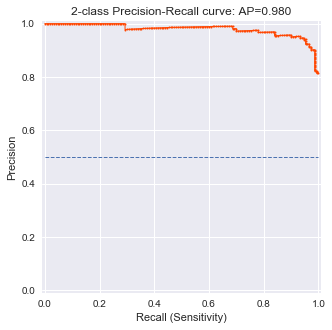

In [44]:
precission_recall_plot(grid_lr, X_test_cut)

**Support Vector Machines**

In [84]:
param_grid_svc = {'kernel':['linear'],
               'gamma':uniform(0.0,0.5),
               'C':uniform(0.25,10.0-0.25)}
#               ,
#               {'kernel':['poly'],
#                'degree':randint(1,7),
#                'C':uniform(0.25,10.0-0.25)}
#               ,
#               {'kernel':['sigmoid'],
#                'C':uniform(0.25,10.0-0.25)}]

In [85]:
grid_svc = RandomizedSearchCV(
                        n_iter=30, 
                        estimator=svc, 
                        cv=StratifiedKFold(10, shuffle=True), 
                        param_distributions=param_grid_svc,
                        scoring='balanced_accuracy',
                        n_jobs=-1
                        )

In [86]:
grid_svc.fit(X_train_cut, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'kernel': ['linear'], 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A00FD883C8>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A00FD8E1D0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)

In [87]:
grid_svc.best_params_

{'C': 7.152447654192508, 'gamma': 0.3998919188092769, 'kernel': 'linear'}

In [88]:
print(classification_report(grid_svc.predict(X_test_cut), y_test))
print('Accuracy: %s' % grid_svc.best_score_)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1940
           1       0.94      0.72      0.82       195

   micro avg       0.97      0.97      0.97      2135
   macro avg       0.96      0.86      0.90      2135
weighted avg       0.97      0.97      0.97      2135

Accuracy: 0.9351805281120892


f1=0.817 auc=0.918 ap=0.919


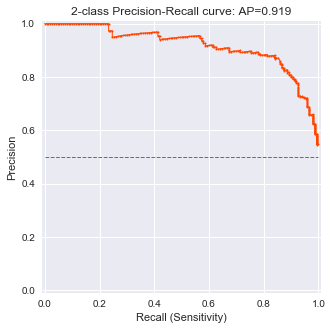

In [89]:
precission_recall_plot(grid_svc, X_test_cut)

### Features engineering for Logistic Regression

First feature engineering was carried out above using L1 regularization with the Logistic Regression

In [51]:
data_adult_cut = data_adult.iloc[:,2:]

#### Variance Threshold

In [52]:
from sklearn.feature_selection import VarianceThreshold

In [53]:
var = VarianceThreshold(threshold=0.1)
var.fit(data_adult_cut)
data_adult_var = var.transform(data_adult_cut)

In [54]:
data_adult_cut.shape, data_adult_var.shape

((5255, 145), (5255, 79))

In [55]:
X_train_var = data_adult_var[:cutoff]
X_test_var = data_adult_var[cutoff:]

In [56]:
X_train_cut.shape, X_train_var.shape

((3120, 145), (3120, 79))

In [57]:
param_grid_vt = {'penalty':['l1','l2'],
              'C':uniform(0.25,10.0-0.25)}

grid_vt = RandomizedSearchCV(
                        n_iter=30, 
                        estimator=lr, 
                        cv=StratifiedKFold(10, shuffle=True), 
                        param_distributions=param_grid_vt,
                        scoring='balanced_accuracy',
                        n_jobs=-1
                        )

grid_vt.fit(X_train_var, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A00E6524A8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)

In [58]:
grid_vt.best_params_

{'C': 3.429661148980174, 'penalty': 'l1'}

In [59]:
print(classification_report(grid_vt.predict(X_test_var), y_test))
print('Accuracy: %s' % grid_vt.best_score_)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1954
           1       0.99      0.82      0.90       181

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.99      0.91      0.95      2135
weighted avg       0.98      0.98      0.98      2135

Accuracy: 0.9845967307346865


f1=0.900 auc=0.988 ap=0.988


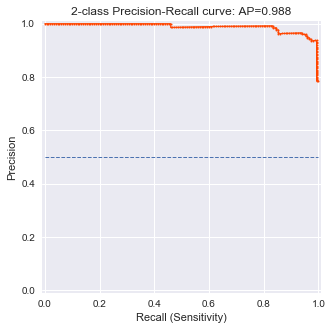

In [60]:
precission_recall_plot(grid_vt, X_test_var)

#### Statistical tests

In [61]:
#TBD: chi^2, ANOVA

#### RFE

In [62]:
from sklearn.feature_selection import RFE, RFECV

In [63]:
rfe_estimator = LogisticRegression(C=2, penalty='l1', class_weight='balanced', solver='liblinear')
# Takes very long time to compute RFECV with StratifiedKfold
# rfe_selector = RFECV(rfe_estimator, step=5, cv=StratifiedKFold(5, shuffle=True))
rfe_selector = RFE(rfe_estimator, step=1)

rfe_selector.fit(data_adult_cut, y)

RFE(estimator=LogisticRegression(C=2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [64]:
data_adult_cut.columns[rfe_selector.get_support()]

Index(['nation_Ecuador', 'nation_Estonia', 'nation_Finland', 'nation_France',
       'nation_Germany', 'nation_Great Britain', 'nation_Ireland',
       'nation_Italy', 'nation_Latvia', 'nation_Norway', 'nation_Poland',
       'nation_Russia', 'nation_Rwanda', 'nation_USA', 'finish_Bielsko-Biała',
       'finish_Bukowina Tatrzańska', 'finish_Katowice', 'finish_Warszawa',
       'finish_Zabrze', 'finish_Zakopane', 'wind_dir_  N', 'wind_dir_  W',
       'wind_dir_ NW', 'wind_dir_SSE', 'wind_dir_WSW', 'age', 'year', 'stage',
       'position', 'gc', 'mount_jerseys', 'point_jerseys', 'sprint_jerseys',
       'youth_jerseys', 'followers', 'total_wins', 'n_stages', 'avg_pos_ovr',
       'avg_time_ovr', 'best_gc_ovr', 'worst_gc_ovr', 'avg_gc_time_ovr',
       'n_top10_ovr', 'n_win_ovr', 'best_pos_ovr_l3', 'best_time_ovr_l3',
       'best_gc_ovr_l3', 'best_gc_time_ovr_l3', 'avg_gc_time_ovr_l3',
       'n_top10_l3', 'n_win_l3', 'perc_top10_ovr', 'perc_win_ovr',
       '2015_fc_rank', '2016_div',

In [65]:
support_columns = data_adult_cut.columns[rfe_selector.get_support()]
data_adult_rfe = data_adult_cut[support_columns]

In [66]:
X_train_rfe = data_adult_rfe.iloc[:cutoff,:]
X_test_rfe = data_adult_rfe.iloc[cutoff:,:]

In [67]:
X_train_rfe.shape

(3120, 72)

In [68]:
param_grid_rfe = {'penalty':['l1','l2'],
              'C':uniform(0.25,10.0-0.25)}

grid_rfe = RandomizedSearchCV(
                        n_iter=30, 
                        estimator=lr, 
                        cv=StratifiedKFold(10, shuffle=True), 
                        param_distributions=param_grid_rfe,
                        scoring='balanced_accuracy',
                        n_jobs=-1
                        )

grid_rfe.fit(X_train_rfe, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A00FDA5C88>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)

In [69]:
grid_rfe.best_params_

{'C': 3.492170279715268, 'penalty': 'l1'}

In [70]:
print(classification_report(grid_rfe.predict(X_test_rfe), y_test))
print('Accuracy: %s' % grid_rfe.best_score_)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1958
           1       0.99      0.84      0.91       177

   micro avg       0.99      0.99      0.99      2135
   macro avg       0.99      0.92      0.95      2135
weighted avg       0.99      0.99      0.99      2135

Accuracy: 0.99105442787857


f1=0.911 auc=0.989 ap=0.989


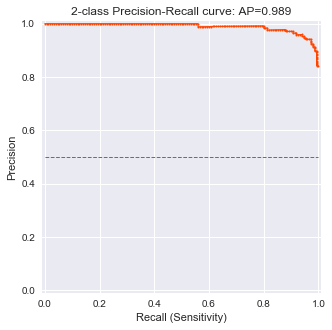

In [71]:
precission_recall_plot(grid_rfe, X_test_rfe)